## Part 2 of: "learning the Q-values with a neural network" ##

In [159]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm_notebook as tqdm
tf.keras.backend.set_floatx('float64')
from misc import *
from collections import deque
from datetime import datetime
import random

In the previous "tutorial" we show that it's possible to learn the uderlying function that relates different arms of a non-linear bandit problem.

\\ 

In this notebook we will do the same, but now we add some "context" to each arm; and still there's a nonlinear function for the mean reward relating differnt arms 

In [160]:
def Prob(alpha, beta, n):
    p0 = np.exp(-(alpha-beta)**2)
    if n == 0:
        return p0
    else:
        return 1-p0

def qval(beta, n, guess):
    #dolinar guessing rule (= max-likelihood for L=1, careful sign of \beta)
    alpha = 0.4
    pn = np.sum([Prob(g*alpha, beta, n) for g in [-1,1]])
    return Prob(guess*alpha, beta, n)/pn


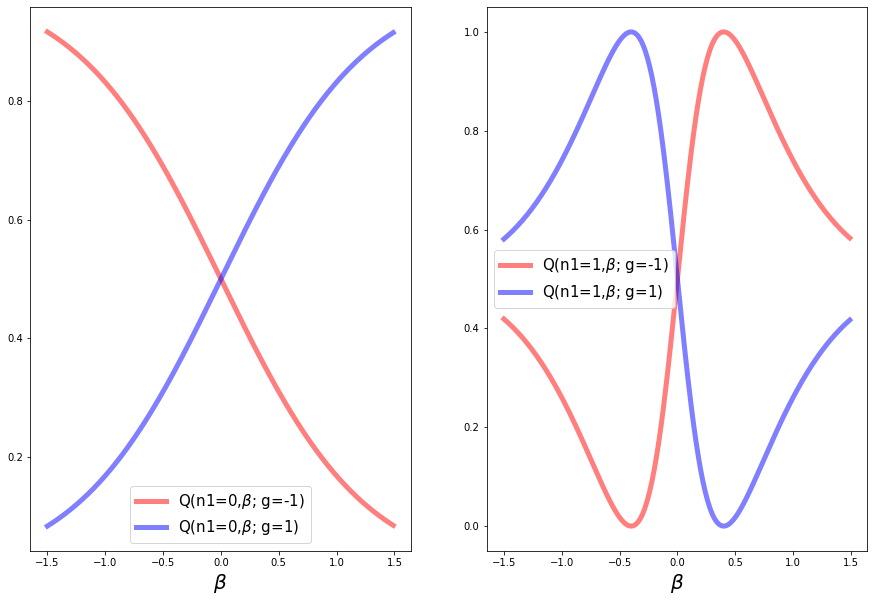

In [3]:
plt.figure(figsize=(15,10))
ax1 =  plt.subplot2grid((1,2),(0,0))
ax2 =  plt.subplot2grid((1,2),(0,1))

betas = np.arange(-1.5,1.5,.01)
ax1.plot(betas,[qval(b, 0, -1) for b in betas],alpha=0.5,c="red", linewidth=5, label="Q(n1=0,"+r'$\beta$'+"; g=-1)")
ax1.plot(betas,[qval(b, 0, 1) for b in betas],alpha=0.5,c="blue",  linewidth=5,label="Q(n1=0,"+r'$\beta$'+"; g=1)")

ax2.plot(betas,[qval(b, 1, -1) for b in betas],alpha=0.5,c="red",  linewidth=5,label="Q(n1=1,"+r'$\beta$'+"; g=-1)")
ax2.plot(betas,[qval(b, 1, 1) for b in betas],alpha=0.5,c="blue",  linewidth=5,label="Q(n1=1,"+r'$\beta$'+"; g=1)")

for ax in [ax1, ax2]:
    ax.set_xlabel(r'$\beta$', size=20)
    ax.legend(prop={"size":15})


Now let's create a dataset; the idea is to sample a reward many times for a given beta.

In [161]:
def createdataset_l2(number_rews_per_beta_per_outcome_per_guess=10**2,number_of_betas = 10):
    #we call it l2 so it does not interfer with the fist tutoral..
    dataset = []
    labels=[]
    global betas_train
    global number_of_samples
    number_of_samples = number_rews_per_beta_per_outcome_per_guess
    betas_train = np.linspace(-1.5,1.5,number_of_betas)
    for i in range(len(betas_train)):
        beta = betas_train[i]
        for outcome in [0.,1.]:
            for guess in [-1.,1.]:

                for k in range(number_rews_per_beta_per_outcome_per_guess):
                    mean_bernoulli = qval(beta, outcome, guess)
                    reward = np.random.choice([1.,0,],1,p=[mean_bernoulli, 1.-mean_bernoulli])[0]

                    dataset.append([beta, outcome, guess, reward])
    return np.array(dataset)

We can plot the data obtained, it's noisy!

Obviously, the more you sample the less noisy the average is!

In [7]:
data = createdataset_l2(10**3)
data = np.split(data, len(betas_train))

In [8]:
mean_values = {}
for index_beta in range(len(betas_train)):
    mean_values[str(index_beta)] = {}

for index_beta, beta in enumerate(betas_train):
    sp = np.split(data[index_beta],4)
    for index_ng in range(4):
        mean_values[str(index_beta)][str(index_ng)]=np.mean(sp[index_ng][:,3])

## Let's see the data! (now it's a bit more involved to plot it, as for a given beta you have some index of n and g ##

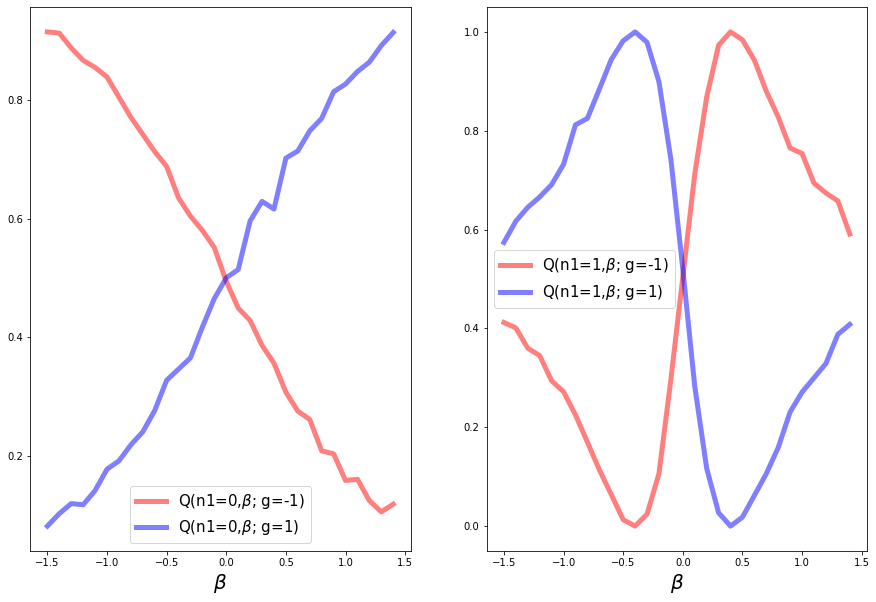

In [9]:
plt.figure(figsize=(15,10))
ax1 =  plt.subplot2grid((1,2),(0,0))
ax2 =  plt.subplot2grid((1,2),(0,1))

betas = np.arange(-1.5,1.5,.01)
ax1.plot(betas_train,[mean_values[str(b)]["0"] for b in range(len(betas_train))],alpha=0.5,c="red", linewidth=5, label="Q(n1=0,"+r'$\beta$'+"; g=-1)")
ax1.plot(betas_train,[mean_values[str(b)]["1"] for b in range(len(betas_train))],alpha=0.5,c="blue",  linewidth=5,label="Q(n1=0,"+r'$\beta$'+"; g=1)")

ax2.plot(betas_train,[mean_values[str(b)]["2"] for b in range(len(betas_train))],alpha=0.5,c="red",  linewidth=5,label="Q(n1=1,"+r'$\beta$'+"; g=-1)")
ax2.plot(betas_train,[mean_values[str(b)]["3"] for b in range(len(betas_train))],alpha=0.5,c="blue",  linewidth=5,label="Q(n1=1,"+r'$\beta$'+"; g=1)")

for ax in [ax1, ax2]:
    ax.set_xlabel(r'$\beta$', size=20)
    ax.legend(prop={"size":15})


## Now we want to train a network, defined below as Net1(), to learn this function over stochastic rewards, as we did in the case of a single $\beta$. The arquitecture we'll use is, as income, $(\beta, n, g)$ and as output $\hat{Q}(\beta, b ; g)$. ##

### Notice the difference in the input_shape=(3,) for self.l1 ##

In [162]:

class Net(tf.keras.Model):
    def __init__(self, valreg=0.01, seed_val=0.1):
        super(Net,self).__init__()

        self.l1 = Dense(50, input_shape=(3,),kernel_initializer=tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),
        bias_initializer = tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),
        kernel_regularizer=tf.keras.regularizers.l1(valreg),
    activity_regularizer=tf.keras.regularizers.l2(valreg))

        self.l2 = Dense(50, kernel_regularizer=tf.keras.regularizers.l1(valreg),
    activity_regularizer=tf.keras.regularizers.l2(valreg),
    kernel_initializer=tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),
    bias_initializer = tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val))
        self.l3 = Dense(50, kernel_regularizer=tf.keras.regularizers.l1(valreg),
    activity_regularizer=tf.keras.regularizers.l2(valreg),
    kernel_initializer=tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),
    bias_initializer = tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val))

        self.l4 = Dense(50, kernel_regularizer=tf.keras.regularizers.l1(valreg),
    activity_regularizer=tf.keras.regularizers.l2(valreg),
    kernel_initializer=tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),
    bias_initializer = tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val))

        self.l5 = Dense(1, kernel_regularizer=tf.keras.regularizers.l1(valreg),
    activity_regularizer=tf.keras.regularizers.l2(valreg),
    kernel_initializer=tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),
    bias_initializer = tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val))

    def call(self, input):
        feat = tf.nn.relu(self.l1(input))
        feat = tf.nn.dropout(feat, rate=0.01)
        feat = tf.nn.relu(self.l2(feat))
        feat = tf.nn.dropout(feat, rate=0.01)
        feat = tf.nn.relu(self.l3(feat))
        feat = tf.nn.relu(self.l4(feat))
        feat = tf.nn.sigmoid(self.l5(feat))
        return feat

    def predict(self, history_one):
        inp = np.expand_dims(history_one, axis=0)
        return np.squeeze(self(inp).numpy())

    def __str__(self):
        return self.name


## How do we feed the network with this food ? ##

In [21]:
data[0]

array([[-1.5,  0. , -1. ,  1. ],
       [-1.5,  0. , -1. ,  1. ],
       [-1.5,  0. , -1. ,  1. ],
       ...,
       [-1.5,  1. ,  1. ,  0. ],
       [-1.5,  1. ,  1. ,  1. ],
       [-1.5,  1. ,  1. ,  0. ]])

In [26]:
food =data[0][:,[0,1,2]]

In [31]:
print(food[:5])

[[-1.5  0.  -1. ]
 [-1.5  0.  -1. ]
 [-1.5  0.  -1. ]
 [-1.5  0.  -1. ]
 [-1.5  0.  -1. ]]


In [32]:
net= Net()
net(food)[:5]

<tf.Tensor: shape=(5, 1), dtype=float64, numpy=
array([[0.50630818],
       [0.50633824],
       [0.50633824],
       [0.50633824],
       [0.50634624]])>

** comment **: the difference in the values is due to the drop-out rate!

### Now that we are convinced we can learn the mean value of a (parametrized) distibution from noisy data, let's see how this get affected if we shuffle the data points (each batch is comoposed from different values of displacements).###

\\



### Notice also that the results are even **better**!###

In [179]:
def learning_problem(rews_per_beta, epochs=30, number_of_splits=100, number_of_betas=10, lr=10**(-3), batch_size=None):
    start = datetime.now()
    optimizer = tf.keras.optimizers.Adam(lr=lr)

    global dataset, net
    dataset = createdataset_l2(rews_per_beta, number_of_betas=number_of_betas)
    dataset_copy = dataset.copy()
    np.random.shuffle(dataset)
    
    if batch_size == None:

        batch_size_here = len(dataset)/number_splits
        dataset = np.split(dataset, number_of_splits + len(dataset)%number_of_splits) #spliting the dataset!
    else:
        splits = len(dataset)/batch_size
        batch_size_here = batch_size
        dataset = np.split(dataset, splits + len(dataset)%splits) #spliting the dataset!
    print("Real number of splits (len(dataset) after spliting): {}\nlen(data[0]: {}\nBatch size: {}\nepochs: {}\nNumber_of_betas: {}\nrews_per_beta: {}\nNumber of data points: {}".format(
            len(dataset),len(dataset[0]),batch_size_here,epochs,number_of_betas,rews_per_beta,rews_per_beta*4*number_of_betas)
         )
    print("")
    net = Net()
    
    
    histo_preds = {} #here i save the predictions

    for epoch in tqdm(range(epochs)):
        epoch_loss_avg = tf.keras.metrics.Mean()

        for batch in tqdm(dataset):
            with tf.GradientTape() as tape:
                tape.watch(net.trainable_variables)
                preds = net(batch[:,[0,1,2]]) #make predictions in batch
                rews = batch[:,3]
                loss = tf.keras.losses.MSE(rews,preds)
                loss = tf.reduce_mean(loss)

                grads = tape.gradient(loss, net.trainable_variables)
                optimizer.apply_gradients(zip(grads, net.trainable_variables))
            epoch_loss_avg(loss)
        print("Epoch {:03d}: Loss: {:.7f}".format(epoch,epoch_loss_avg.result()))

        if (epoch % int(epochs/5) == 0)|(epoch==length_training-1):

            histo_preds[str(epoch)] ={} 
            histo_preds[str(epoch)]["epoch_number"] = epoch
            histo_preds[str(epoch)]["values"] = {}

            index=0
            for n1 in [0.,1.]:
                for guess in [-1.,1.]:
                    foo =np.array([[b,n1,guess] for b in betas_train]) #betas_train defined as global in create_dataset_l2()
                    histo_preds[str(epoch)]["values"][str(index)] = np.squeeze(net(foo))
                    index+=1
    
    
    dataavg = np.split(dataset_copy, len(betas_train))

    mean_values = {}
    for index_beta in range(len(betas_train)):
        mean_values[str(index_beta)] = {}

    for index_beta, beta in enumerate(betas_train):
        sp = np.split(dataavg[index_beta],4)
        for index_ng in range(4):
            mean_values[str(index_beta)][str(index_ng)]=np.mean(sp[index_ng][:,3])

    print("Tardé: ", datetime.now()-start)
    return histo_preds, mean_values, net
    
    
#in this case the length is 500*4*30, 4 'cause the n1 and guess, 30 'cause the len(betas_train)

In [ ]:
histo_preds, mean_values, _ = learning_problem(10,epochs=10, batch_size=1000,number_of_betas=10) 


## As the training takes more time, let us define a function to plot the results.. ##

In [164]:
def plot_results(histo_preds, mean_values, title=None):
    plt.figure(figsize=(15,15))
    ax1 =  plt.subplot2grid((1,2),(0,0))
    ax2 =  plt.subplot2grid((1,2),(0,1))

    betas = np.arange(-1.5,1.5,.01)
    ax1.plot(betas_train,[mean_values[str(b)]["0"] for b in range(len(betas_train))],'--',alpha=0.85,c="red", linewidth=5, label="Q(n1=0,"+r'$\beta$'+"; g=-1)")
    ax1.plot(betas_train,[mean_values[str(b)]["1"] for b in range(len(betas_train))],'--',alpha=0.85,c="blue",  linewidth=5,label="Q(n1=0,"+r'$\beta$'+"; g=1)")

    ax2.plot(betas_train,[mean_values[str(b)]["2"] for b in range(len(betas_train))],'--',alpha=0.85,c="red",  linewidth=5,label="Q(n1=1,"+r'$\beta$'+"; g=-1)")
    ax2.plot(betas_train,[mean_values[str(b)]["3"] for b in range(len(betas_train))],'--',alpha=0.85,c="blue",  linewidth=5,label="Q(n1=1,"+r'$\beta$'+"; g=1)")

    
    for predictions in histo_preds.values():
        ax1.plot(betas_train,predictions["values"]["0"],alpha=0.5, linewidth=5, label="epoch: "+str(predictions["epoch_number"])) #, label=r'$\hat{Q}$'+"(n1=0,"+r'$\beta$'+"; g=-1)")
        ax1.plot(betas_train,predictions["values"]["1"],alpha=0.5, linewidth=5)#, label="epoch: "+str(predictions["epoch_number"]))#,label=r'$\hat{Q}$'+"(n1=0,"+r'$\beta$'+"; g=1)")

        ax2.plot(betas_train,predictions["values"]["2"] ,alpha=0.5,  linewidth=5)#, label="epoch: "+str(predictions["epoch_number"]))#label=r'$\hat{Q}$'+"(n1=1,"+r'$\beta$'+"; g=-1)")
        ax2.plot(betas_train,predictions["values"]["3"] ,alpha=0.5,  linewidth=5, label="epoch: "+str(predictions["epoch_number"]))#,label=r'$\hat{Q}$'+"(n1=1,"+r'$\beta$'+"; g=1)")
    
    #Now we take the last and plot it in bold!
    ax1.plot(betas_train,predictions["values"]["0"],alpha=0.85, c="black",linewidth=5, label="epoch: "+str(predictions["epoch_number"])) #, label=r'$\hat{Q}$'+"(n1=0,"+r'$\beta$'+"; g=-1)")
    ax1.plot(betas_train,predictions["values"]["1"],alpha=0.85, c="black", linewidth=5)#, label="epoch: "+str(predictions["epoch_number"]))#,label=r'$\hat{Q}$'+"(n1=0,"+r'$\beta$'+"; g=1)")

    ax2.plot(betas_train,predictions["values"]["2"] ,alpha=0.85, c="black", linewidth=5)#, label="epoch: "+str(predictions["epoch_number"]))#label=r'$\hat{Q}$'+"(n1=1,"+r'$\beta$'+"; g=-1)")
    ax2.plot(betas_train,predictions["values"]["3"] ,alpha=0.85,  c="black",linewidth=5, label="epoch: "+str(predictions["epoch_number"]))#,label=r'$\hat{Q}$'+"(n1=1,"+r'$\beta$'+"; g=1)")
        
    ax1.scatter(betas_train,predictions["values"]["0"],alpha=0.85, c="black",s=150)
    ax1.scatter(betas_train,predictions["values"]["1"],alpha=0.85, c="black",s=150)

    ax2.scatter(betas_train,predictions["values"]["2"],alpha=0.85, c="black",s=150)
    ax2.scatter(betas_train,predictions["values"]["3"],alpha=0.85, c="black",s=150)

        
    for ax in [ax1, ax2]:
        ax.set_xlabel(r'$\beta$', size=20)
        ax.legend(prop={"size":15})
    if title != None:
        plt.suptitle(title, size=50)
    return

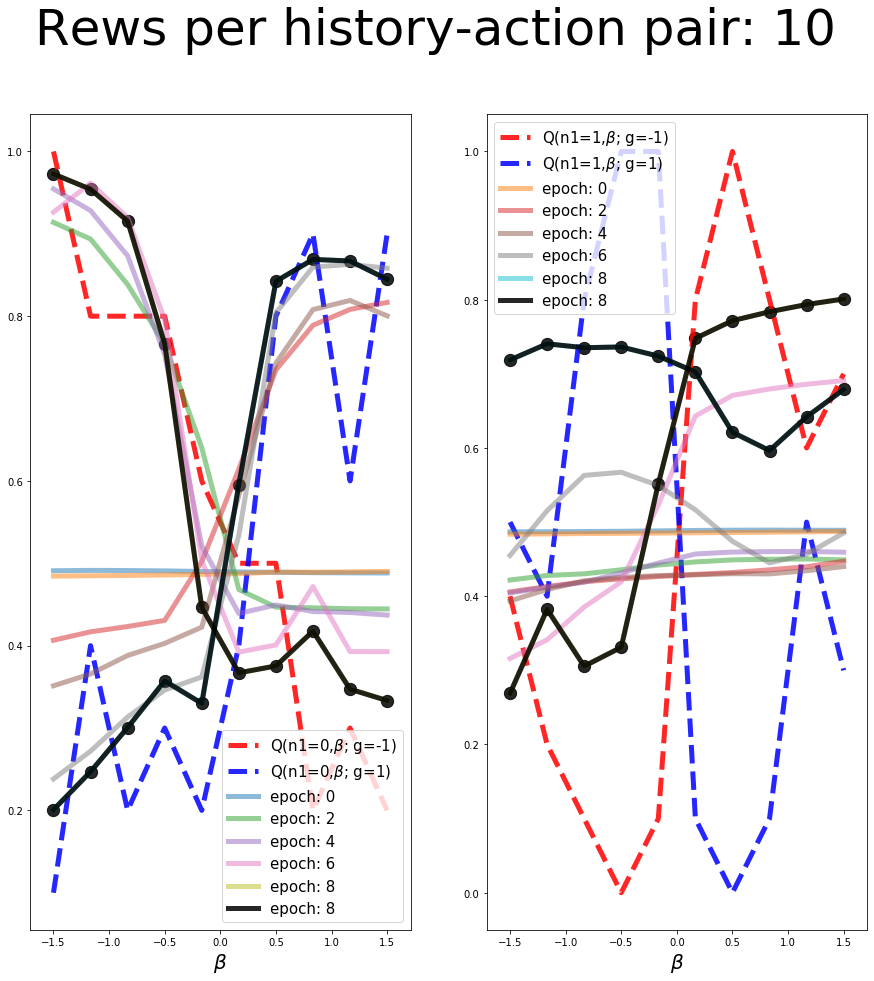

In [97]:
plot_results(histo_preds,mean_values, title="Rews per history-action pair: 10")

## Ok, now let's take a bit more of data ##

Training with batch_size of:  100.0


Epoch 000: Loss: 0.250


Epoch 020: Loss: 0.250


Epoch 040: Loss: 0.250


Epoch 060: Loss: 0.250


Epoch 080: Loss: 0.250


Epoch 099: Loss: 0.250
Tardé:  0:17:18.091112


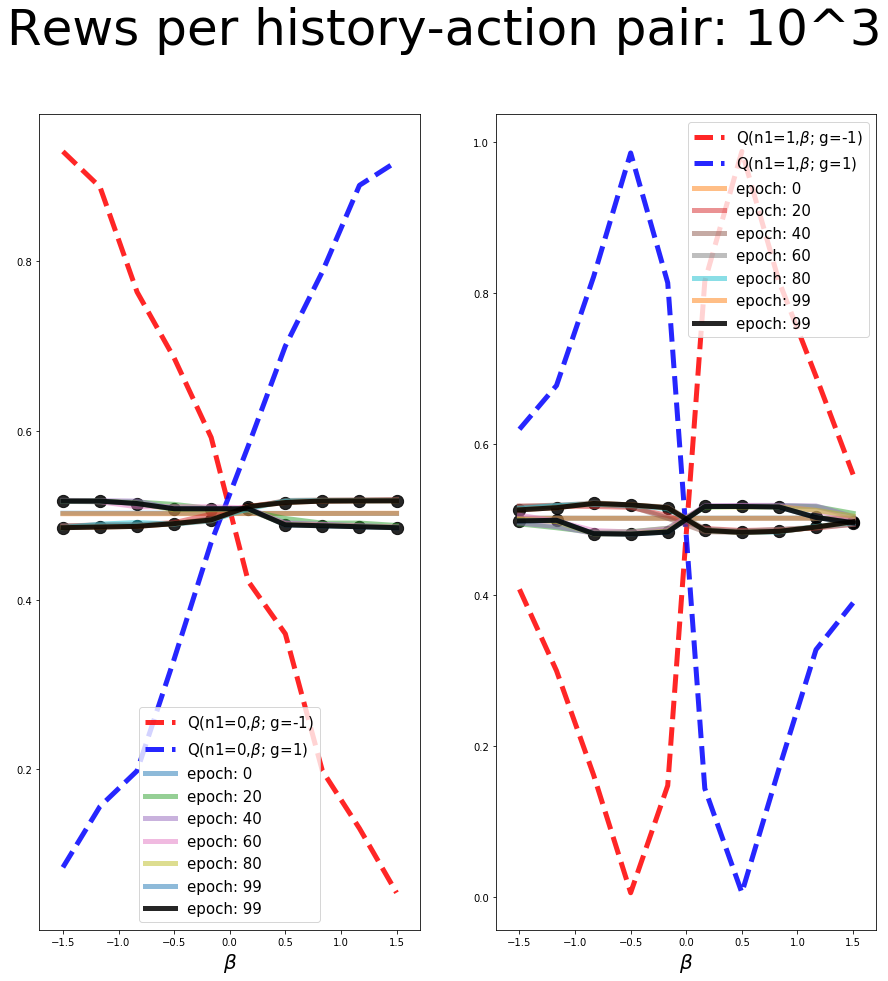

In [141]:
histo_preds1, mean_values1,_ = learning_problem(500,epochs=100, number_of_splits=1000,number_of_betas=10) 
plot_results(histo_preds1,mean_values1, title="Rews per history-action pair: 10^3")

## Let's try with more splits (smaller batch_size, and more batches)##

Training with batch_size of:  2.0


Epoch 000: Loss: 0.250


Epoch 002: Loss: 0.207


Epoch 004: Loss: 0.170


Epoch 006: Loss: 0.167


Epoch 008: Loss: 0.166


Tardé:  0:00:42.654236


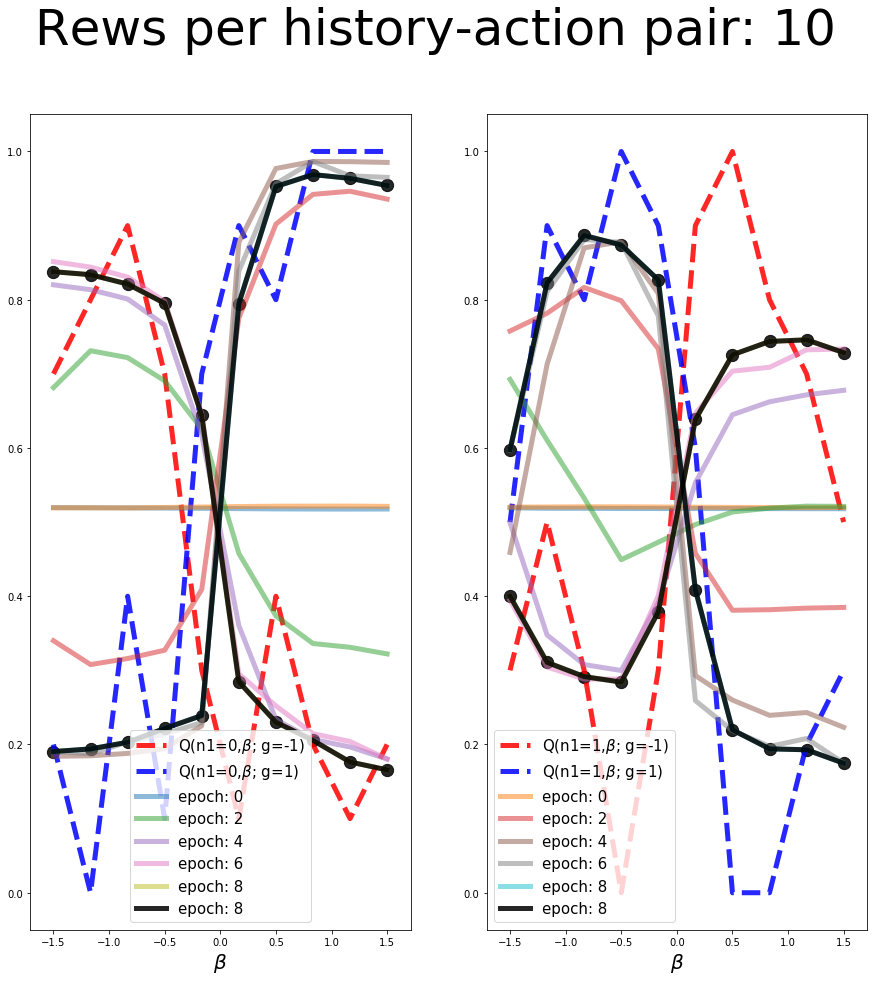

In [144]:
histo_preds1, mean_values1,_ = learning_problem(10,epochs=10, number_of_splits=400,number_of_betas=10) 
plot_results(histo_preds1,mean_values1, title="Rews per history-action pair: 10")

## Let's try now with 100 rewards ##

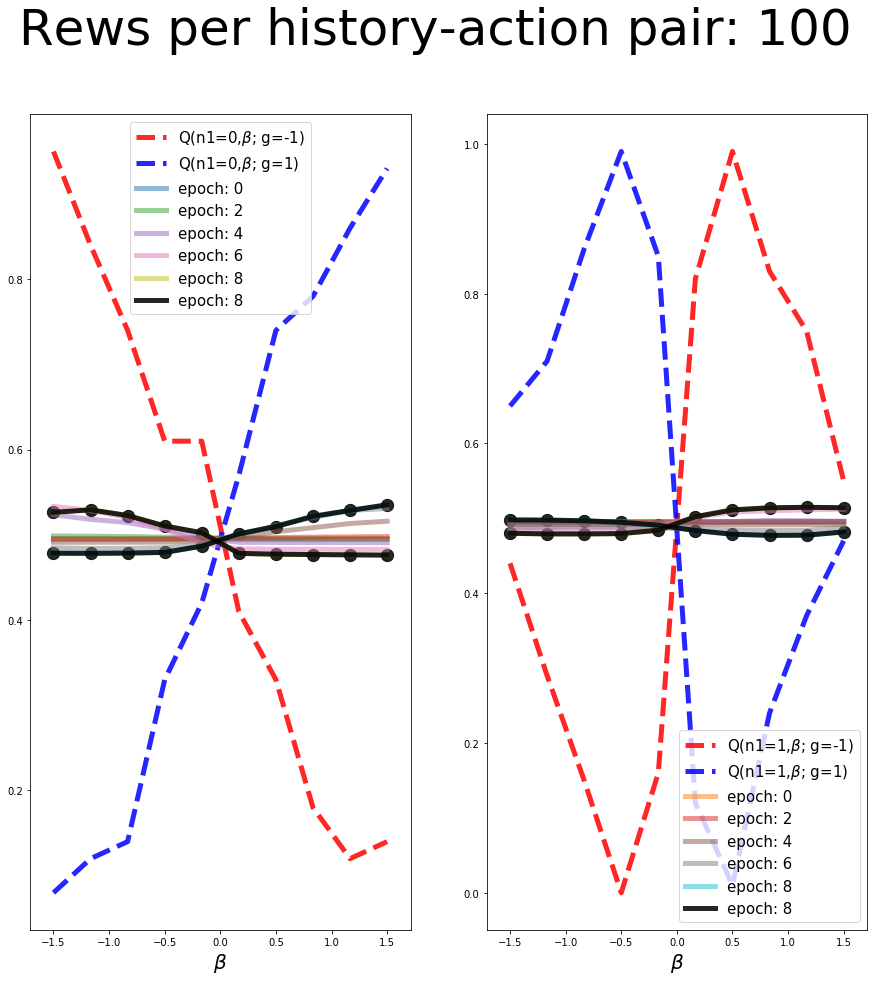

In [151]:
histo_preds1, mean_values1,_ = learning_problem(100,epochs=10, number_of_splits=400,number_of_betas=10) 
plot_results(histo_preds1,mean_values1, title="Rews per history-action pair: 100")

** does not work any more! ** Let's change the learning rate

Training with batch_size of:  20.0


Epoch 000: Loss: 0.250


Epoch 002: Loss: 0.250


Epoch 004: Loss: 0.250


Epoch 006: Loss: 0.250


Epoch 008: Loss: 0.250


Tardé:  0:00:41.598483


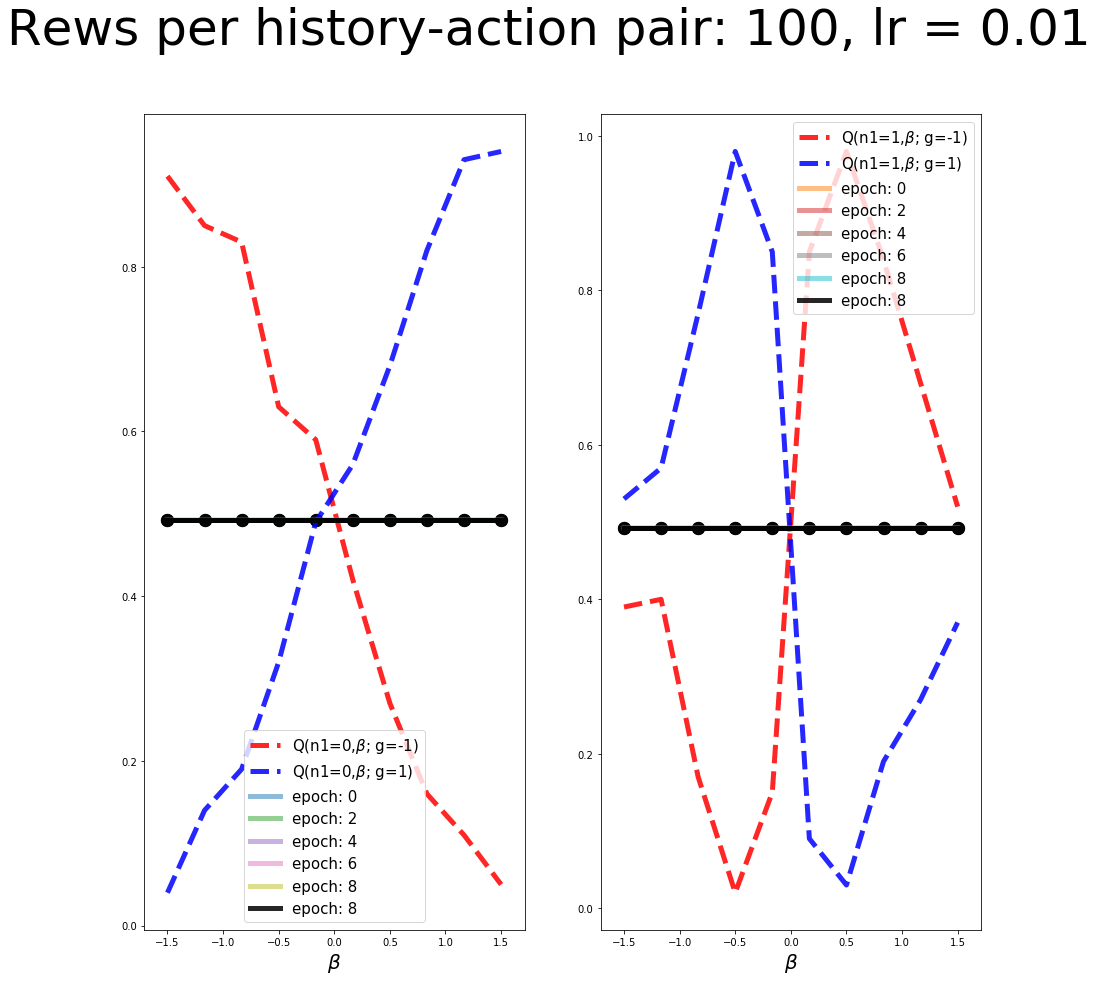

In [152]:
histo_preds1, mean_values1,_ = learning_problem(100,epochs=10, number_of_splits=400,number_of_betas=10, lr=0.01) 
plot_results(histo_preds1,mean_values1, title="Rews per history-action pair: 100, lr = 0.01")

## Let's leave more time the first one ##

Training with batch_size of:  20.0


Epoch 000: Loss: 0.250


Epoch 010: Loss: 0.250


Epoch 020: Loss: 0.249


Epoch 030: Loss: 0.249


Epoch 040: Loss: 0.249


Tardé:  0:03:29.446338


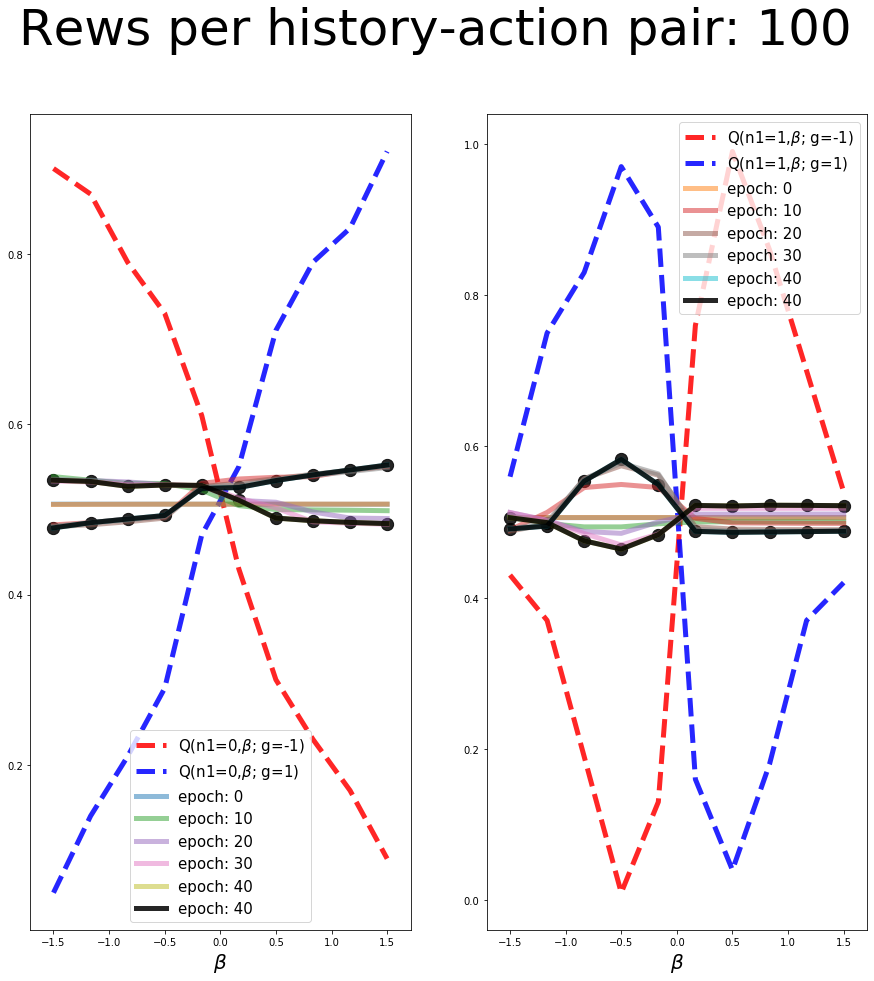

In [153]:
histo_preds1, mean_values1,_ = learning_problem(100,epochs=50, number_of_splits=400,number_of_betas=10) 
plot_results(histo_preds1,mean_values1, title="Rews per history-action pair: 100")

## Let's go back to the success ##

Training with batch_size of:  20.0


Epoch 000: Loss: 0.204


Epoch 002: Loss: 0.168


Epoch 004: Loss: 0.167


Epoch 006: Loss: 0.165


Epoch 008: Loss: 0.164


Tardé:  0:06:33.245354


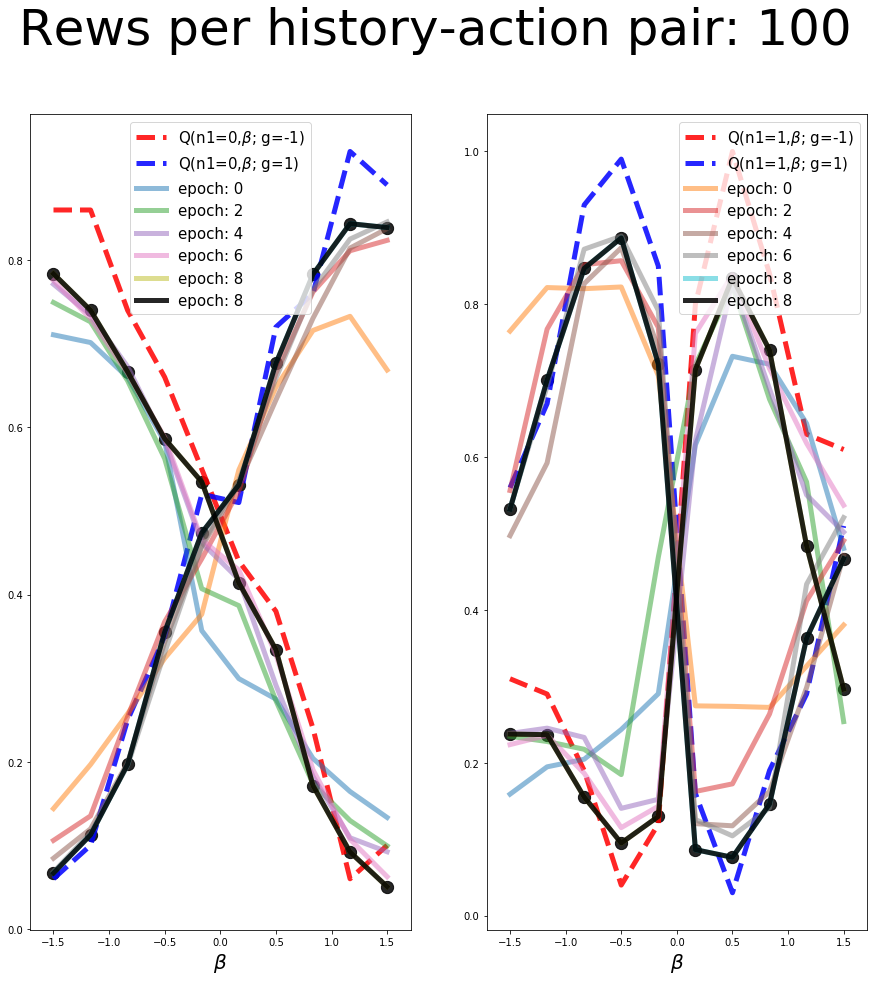

In [158]:
histo_preds1, mean_values1,_ = learning_problem(100,epochs=10, number_of_splits=4000,number_of_betas=10) 
plot_results(histo_preds1,mean_values1, title="Rews per history-action pair: 100")

## Batch size of 16 ##

Real number of splits (len(dataset) after spliting): 125
len(data[0]: 32
Batch size: 32
epochs: 30
Number_of_betas: 10
rews_per_beta: 100
Number of data points: 4000



Epoch 000: Loss: 0.250


Epoch 001: Loss: 0.250


Epoch 002: Loss: 0.250


Epoch 003: Loss: 0.250


Epoch 004: Loss: 0.250


Epoch 005: Loss: 0.250


Epoch 006: Loss: 0.250


Epoch 007: Loss: 0.250


Epoch 008: Loss: 0.250


Epoch 009: Loss: 0.250


Epoch 010: Loss: 0.250


Epoch 011: Loss: 0.250


Epoch 012: Loss: 0.250


Epoch 013: Loss: 0.250


Epoch 014: Loss: 0.250


Epoch 015: Loss: 0.250


Epoch 016: Loss: 0.250


Epoch 017: Loss: 0.250


Epoch 018: Loss: 0.250


Epoch 019: Loss: 0.250


Epoch 020: Loss: 0.250


Epoch 021: Loss: 0.250


Epoch 022: Loss: 0.250


Epoch 023: Loss: 0.250


Epoch 024: Loss: 0.250


Epoch 025: Loss: 0.250


Epoch 026: Loss: 0.250


Epoch 027: Loss: 0.250


Epoch 028: Loss: 0.250


Epoch 029: Loss: 0.250
Tardé:  0:00:42.153428


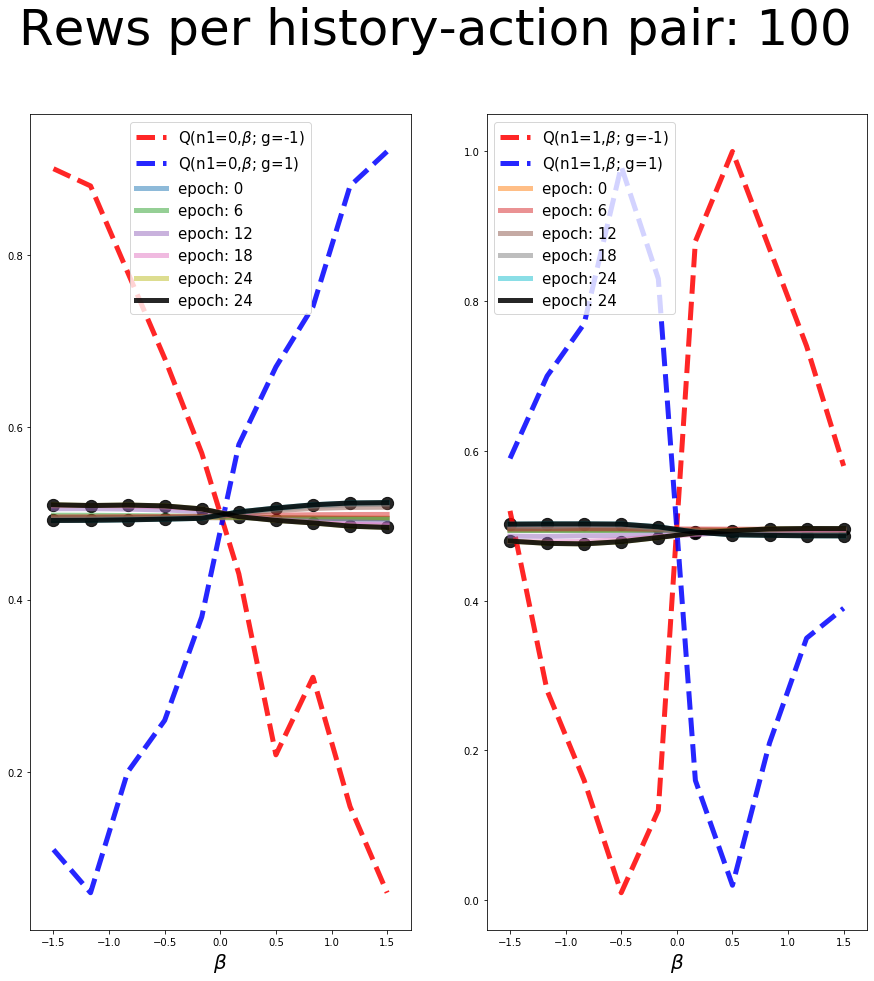

In [176]:
histo_preds1, mean_values1,_ = learning_problem(100,epochs=30, number_of_splits=400,number_of_betas=10, batch_size=32) 
plot_results(histo_preds1,mean_values1, title="Rews per history-action pair: 100")

Real number of splits (len(dataset) after spliting): 125
len(data[0]: 32
Batch size: 32
epochs: 30
Number_of_betas: 10
rews_per_beta: 100
Number of data points: 4000



Epoch 000: Loss: 0.251


Epoch 001: Loss: 0.252


Epoch 002: Loss: 0.251


Epoch 003: Loss: 0.251


Epoch 004: Loss: 0.251


Epoch 005: Loss: 0.251


Epoch 006: Loss: 0.251


Epoch 007: Loss: 0.251


Epoch 008: Loss: 0.251


Epoch 009: Loss: 0.251


Epoch 010: Loss: 0.251


Epoch 011: Loss: 0.251


Epoch 012: Loss: 0.251


Epoch 013: Loss: 0.251


Epoch 014: Loss: 0.251


Epoch 015: Loss: 0.251


Epoch 016: Loss: 0.251


Epoch 017: Loss: 0.251


Epoch 018: Loss: 0.251


Epoch 019: Loss: 0.251


Epoch 020: Loss: 0.251


Epoch 021: Loss: 0.251


Epoch 022: Loss: 0.251


Epoch 023: Loss: 0.251


Epoch 024: Loss: 0.251


Epoch 025: Loss: 0.251


Epoch 026: Loss: 0.251


Epoch 027: Loss: 0.251


Epoch 028: Loss: 0.251


Epoch 029: Loss: 0.251
Tardé:  0:00:44.240829


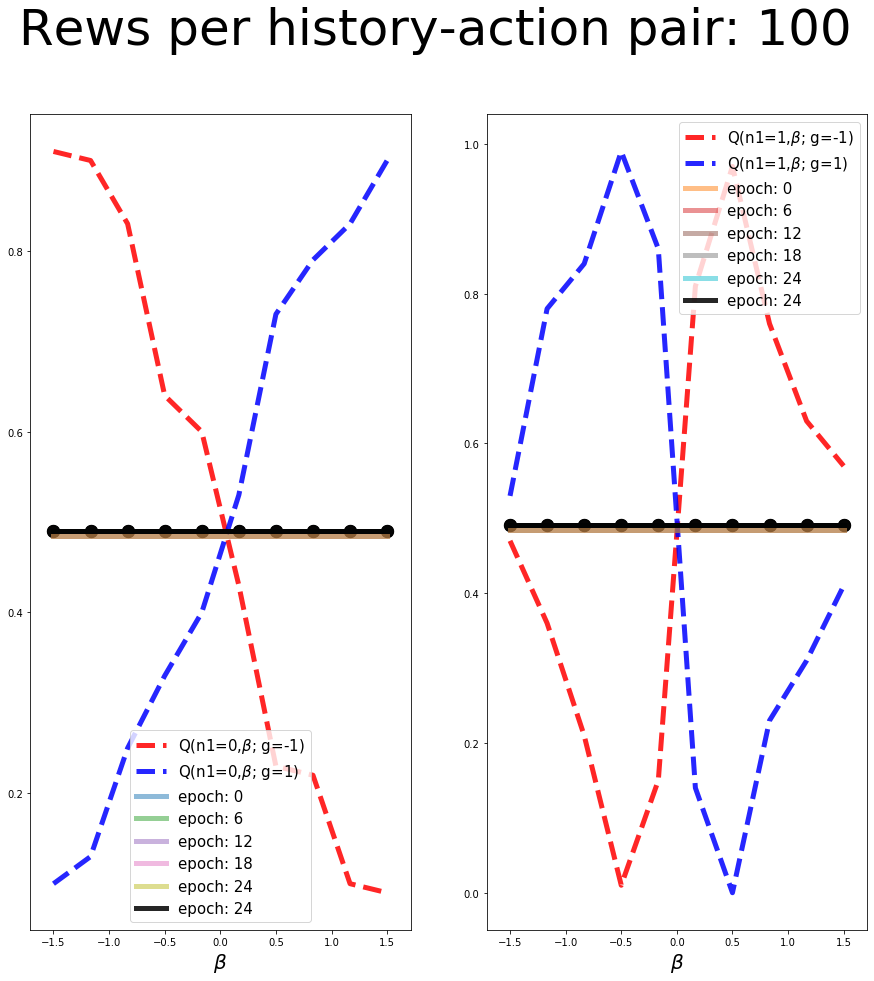

In [177]:
histo_preds1, mean_values1,_ = learning_problem(100,epochs=30, number_of_splits=400,number_of_betas=10, batch_size=32, lr=0.1) 
plot_results(histo_preds1,mean_values1, title="Rews per history-action pair: 100")

Real number of splits (len(dataset) after spliting): 125
len(data[0]: 32
Batch size: 32
epochs: 300
Number_of_betas: 10
rews_per_beta: 100
Number of data points: 4000



Epoch 000: Loss: 0.2500578


Epoch 001: Loss: 0.2499683


Epoch 002: Loss: 0.2499590


Epoch 003: Loss: 0.2499526


Epoch 004: Loss: 0.2499474


Epoch 005: Loss: 0.2499423


Epoch 006: Loss: 0.2499380


Epoch 007: Loss: 0.2499351


Epoch 008: Loss: 0.2499293


Epoch 009: Loss: 0.2499275


Epoch 010: Loss: 0.2499233


Epoch 011: Loss: 0.2499205


Epoch 012: Loss: 0.2499188


Epoch 013: Loss: 0.2499160


Epoch 014: Loss: 0.2499128


Epoch 015: Loss: 0.2499125


Epoch 016: Loss: 0.2499099


Epoch 017: Loss: 0.2499080


Epoch 018: Loss: 0.2499074


Epoch 019: Loss: 0.2499065


Epoch 020: Loss: 0.2499043


Epoch 021: Loss: 0.2499041


Epoch 022: Loss: 0.2499018


Epoch 023: Loss: 0.2498994


Epoch 024: Loss: 0.2498978


Epoch 025: Loss: 0.2498940


Epoch 026: Loss: 0.2498931


Epoch 027: Loss: 0.2498918


Epoch 028: Loss: 0.2498876


Epoch 029: Loss: 0.2498851


Epoch 030: Loss: 0.2498821


Epoch 031: Loss: 0.2498789


Epoch 032: Loss: 0.2498787


Epoch 033: Loss: 0.2498731


Epoch 034: Loss: 0.2498783


Epoch 035: Loss: 0.2498722


Epoch 036: Loss: 0.2498737


Epoch 037: Loss: 0.2498697


Epoch 038: Loss: 0.2498657


Epoch 039: Loss: 0.2498664


Epoch 040: Loss: 0.2498649


Epoch 041: Loss: 0.2498634


Epoch 042: Loss: 0.2498632


Epoch 043: Loss: 0.2498614


Epoch 044: Loss: 0.2498603


Epoch 045: Loss: 0.2498599


Epoch 046: Loss: 0.2498591


Epoch 047: Loss: 0.2498566


Epoch 048: Loss: 0.2498569


Epoch 049: Loss: 0.2498576


Epoch 050: Loss: 0.2498563


Epoch 051: Loss: 0.2498547


Epoch 052: Loss: 0.2498550


Epoch 053: Loss: 0.2498533


Epoch 054: Loss: 0.2498517


Epoch 055: Loss: 0.2498502


Epoch 056: Loss: 0.2498487


Epoch 057: Loss: 0.2498493


Epoch 058: Loss: 0.2498486


Epoch 059: Loss: 0.2498467


Epoch 060: Loss: 0.2498473


Epoch 061: Loss: 0.2498446


Epoch 062: Loss: 0.2498470


Epoch 063: Loss: 0.2498480


Epoch 064: Loss: 0.2498446


Epoch 065: Loss: 0.2498448


Epoch 066: Loss: 0.2498428


Epoch 067: Loss: 0.2498424


Epoch 068: Loss: 0.2498415


Epoch 069: Loss: 0.2498407


Epoch 070: Loss: 0.2498393


Epoch 071: Loss: 0.2498364


Epoch 072: Loss: 0.2498403


Epoch 073: Loss: 0.2498341


Epoch 074: Loss: 0.2498328


Epoch 075: Loss: 0.2498360


Epoch 076: Loss: 0.2498352


Epoch 077: Loss: 0.2498318


Epoch 078: Loss: 0.2498311


Epoch 079: Loss: 0.2498332


Epoch 080: Loss: 0.2498306


Epoch 081: Loss: 0.2498340


Epoch 082: Loss: 0.2498254


Epoch 083: Loss: 0.2498311


Epoch 084: Loss: 0.2498268


Epoch 085: Loss: 0.2498298


Epoch 086: Loss: 0.2498279


Epoch 087: Loss: 0.2498290


Epoch 088: Loss: 0.2498265


Epoch 089: Loss: 0.2498260


Epoch 090: Loss: 0.2498250


Epoch 091: Loss: 0.2498225


Epoch 092: Loss: 0.2498295


Epoch 093: Loss: 0.2498270


Epoch 094: Loss: 0.2498288


Epoch 095: Loss: 0.2498274


Epoch 096: Loss: 0.2498245


Epoch 097: Loss: 0.2498261


Epoch 098: Loss: 0.2498213


Epoch 099: Loss: 0.2498252


Epoch 100: Loss: 0.2498264


Epoch 101: Loss: 0.2498237


Epoch 102: Loss: 0.2498210


Epoch 103: Loss: 0.2498235


Epoch 104: Loss: 0.2498261


Epoch 105: Loss: 0.2498231


Epoch 106: Loss: 0.2498291


Epoch 107: Loss: 0.2498279


Epoch 108: Loss: 0.2498195


Epoch 109: Loss: 0.2498232


Epoch 110: Loss: 0.2498220


Epoch 111: Loss: 0.2498222


Epoch 112: Loss: 0.2498198


Epoch 113: Loss: 0.2498240


Epoch 114: Loss: 0.2498216


Epoch 115: Loss: 0.2498177


Epoch 116: Loss: 0.2498224


Epoch 117: Loss: 0.2498223


Epoch 118: Loss: 0.2498206


Epoch 119: Loss: 0.2498170


Epoch 120: Loss: 0.2498217


Epoch 121: Loss: 0.2498240


Epoch 122: Loss: 0.2498207


Epoch 123: Loss: 0.2498169


Epoch 124: Loss: 0.2498184


Epoch 125: Loss: 0.2498220


Epoch 126: Loss: 0.2498176


Epoch 127: Loss: 0.2498218


Epoch 128: Loss: 0.2498220


Epoch 129: Loss: 0.2498184


Epoch 130: Loss: 0.2498200


Epoch 131: Loss: 0.2498231


Epoch 132: Loss: 0.2498229


Epoch 133: Loss: 0.2498214


Epoch 134: Loss: 0.2498162


Epoch 135: Loss: 0.2498203


Epoch 136: Loss: 0.2498181


Epoch 137: Loss: 0.2498157


Epoch 138: Loss: 0.2498201


Epoch 139: Loss: 0.2498182


Epoch 140: Loss: 0.2498198


Epoch 141: Loss: 0.2498178


Epoch 142: Loss: 0.2498180


Epoch 143: Loss: 0.2498179


Epoch 144: Loss: 0.2498203


Epoch 145: Loss: 0.2498163


Epoch 146: Loss: 0.2498192


Epoch 147: Loss: 0.2498165


Epoch 148: Loss: 0.2498148


Epoch 149: Loss: 0.2498198


Epoch 150: Loss: 0.2498177


Epoch 151: Loss: 0.2498193


Epoch 152: Loss: 0.2498184


Epoch 153: Loss: 0.2498151


Epoch 154: Loss: 0.2498136


Epoch 155: Loss: 0.2498174


Epoch 156: Loss: 0.2498177


Epoch 157: Loss: 0.2498180


Epoch 158: Loss: 0.2498158


Epoch 159: Loss: 0.2498117


Epoch 160: Loss: 0.2498163


Epoch 161: Loss: 0.2498210


Epoch 162: Loss: 0.2498197


Epoch 163: Loss: 0.2498187


Epoch 164: Loss: 0.2498178


Epoch 165: Loss: 0.2498188


Epoch 166: Loss: 0.2498153


Epoch 167: Loss: 0.2498150


Epoch 168: Loss: 0.2498145


Epoch 169: Loss: 0.2498135


Epoch 170: Loss: 0.2498366


Epoch 171: Loss: 0.2498142


Epoch 172: Loss: 0.2498172


Epoch 173: Loss: 0.2498173


Epoch 174: Loss: 0.2498146


Epoch 175: Loss: 0.2498148


Epoch 176: Loss: 0.2498171


Epoch 177: Loss: 0.2498163


Epoch 178: Loss: 0.2498127


Epoch 179: Loss: 0.2498145


Epoch 180: Loss: 0.2498199


Epoch 181: Loss: 0.2498223


Epoch 182: Loss: 0.2498177


Epoch 183: Loss: 0.2498158


Epoch 184: Loss: 0.2498186


Epoch 185: Loss: 0.2498149


Epoch 186: Loss: 0.2498144


Epoch 187: Loss: 0.2498097


Epoch 188: Loss: 0.2498147


Epoch 189: Loss: 0.2498140


Epoch 190: Loss: 0.2498097


Epoch 191: Loss: 0.2498067


Epoch 192: Loss: 0.2498134


Epoch 193: Loss: 0.2498167


Epoch 194: Loss: 0.2498122


Epoch 195: Loss: 0.2498137


Epoch 196: Loss: 0.2498126


Epoch 197: Loss: 0.2498086


Epoch 198: Loss: 0.2498151


Epoch 199: Loss: 0.2498124


Epoch 200: Loss: 0.2498129


Epoch 201: Loss: 0.2498096


Epoch 202: Loss: 0.2498062


Epoch 203: Loss: 0.2498148


Epoch 204: Loss: 0.2498123


Epoch 205: Loss: 0.2498124


Epoch 206: Loss: 0.2498152


Epoch 207: Loss: 0.2498132


Epoch 208: Loss: 0.2498188


Epoch 209: Loss: 0.2498148


Epoch 210: Loss: 0.2498075


Epoch 211: Loss: 0.2498102


Epoch 212: Loss: 0.2498094


Epoch 213: Loss: 0.2498134


Epoch 214: Loss: 0.2498098


Epoch 215: Loss: 0.2498099


Epoch 216: Loss: 0.2498093


Epoch 217: Loss: 0.2498125


Epoch 218: Loss: 0.2498114


Epoch 219: Loss: 0.2498100


Epoch 220: Loss: 0.2498063


Epoch 221: Loss: 0.2498109


Epoch 222: Loss: 0.2498069


Epoch 223: Loss: 0.2498088


Epoch 224: Loss: 0.2498123


Epoch 225: Loss: 0.2498077


Epoch 226: Loss: 0.2498111


Epoch 227: Loss: 0.2498101


Epoch 228: Loss: 0.2498107


Epoch 229: Loss: 0.2498062


Epoch 230: Loss: 0.2498099


Epoch 231: Loss: 0.2498099


Epoch 232: Loss: 0.2498126


Epoch 233: Loss: 0.2498091


Epoch 234: Loss: 0.2498104


Epoch 235: Loss: 0.2498128


Epoch 236: Loss: 0.2498093


Epoch 237: Loss: 0.2498109


Epoch 238: Loss: 0.2498078


Epoch 239: Loss: 0.2498117


Epoch 240: Loss: 0.2498111


Epoch 241: Loss: 0.2498109


Epoch 242: Loss: 0.2498080


Epoch 243: Loss: 0.2498065


Epoch 244: Loss: 0.2498135


Epoch 245: Loss: 0.2498143


Epoch 246: Loss: 0.2498067


Epoch 247: Loss: 0.2498119


Epoch 248: Loss: 0.2498071


Epoch 249: Loss: 0.2498083


Epoch 250: Loss: 0.2498047


Epoch 251: Loss: 0.2498040


Epoch 252: Loss: 0.2498070


Epoch 253: Loss: 0.2498097


Epoch 254: Loss: 0.2498092


Epoch 255: Loss: 0.2498114


Epoch 256: Loss: 0.2498073


Epoch 257: Loss: 0.2498136


Epoch 258: Loss: 0.2498067


Epoch 259: Loss: 0.2498067


Epoch 260: Loss: 0.2498093


Epoch 261: Loss: 0.2498066


Epoch 262: Loss: 0.2498091


Epoch 263: Loss: 0.2498028


Epoch 264: Loss: 0.2498067


Epoch 265: Loss: 0.2498069


Epoch 266: Loss: 0.2498089


Epoch 267: Loss: 0.2498107


Epoch 268: Loss: 0.2498067


Epoch 269: Loss: 0.2498071


Epoch 270: Loss: 0.2498055


Epoch 271: Loss: 0.2498058


Epoch 272: Loss: 0.2498042


Epoch 273: Loss: 0.2498026


Epoch 274: Loss: 0.2498094


Epoch 275: Loss: 0.2498056


Epoch 276: Loss: 0.2498012


Epoch 277: Loss: 0.2498066


Epoch 278: Loss: 0.2498086


Epoch 279: Loss: 0.2498067


Epoch 280: Loss: 0.2498030


Epoch 281: Loss: 0.2498101


Epoch 282: Loss: 0.2498038


Epoch 283: Loss: 0.2498124


Epoch 284: Loss: 0.2498064


Epoch 285: Loss: 0.2498088


Epoch 286: Loss: 0.2498058


Epoch 287: Loss: 0.2498113


Epoch 288: Loss: 0.2498052


Epoch 289: Loss: 0.2498056


Epoch 290: Loss: 0.2498039


Epoch 291: Loss: 0.2498046


Epoch 292: Loss: 0.2498073


Epoch 293: Loss: 0.2498072


Epoch 294: Loss: 0.2498043


Epoch 295: Loss: 0.2498068


Epoch 296: Loss: 0.2498049


Epoch 297: Loss: 0.2498034


Epoch 298: Loss: 0.2498078


Epoch 299: Loss: 0.2498084
Tardé:  0:06:39.977659


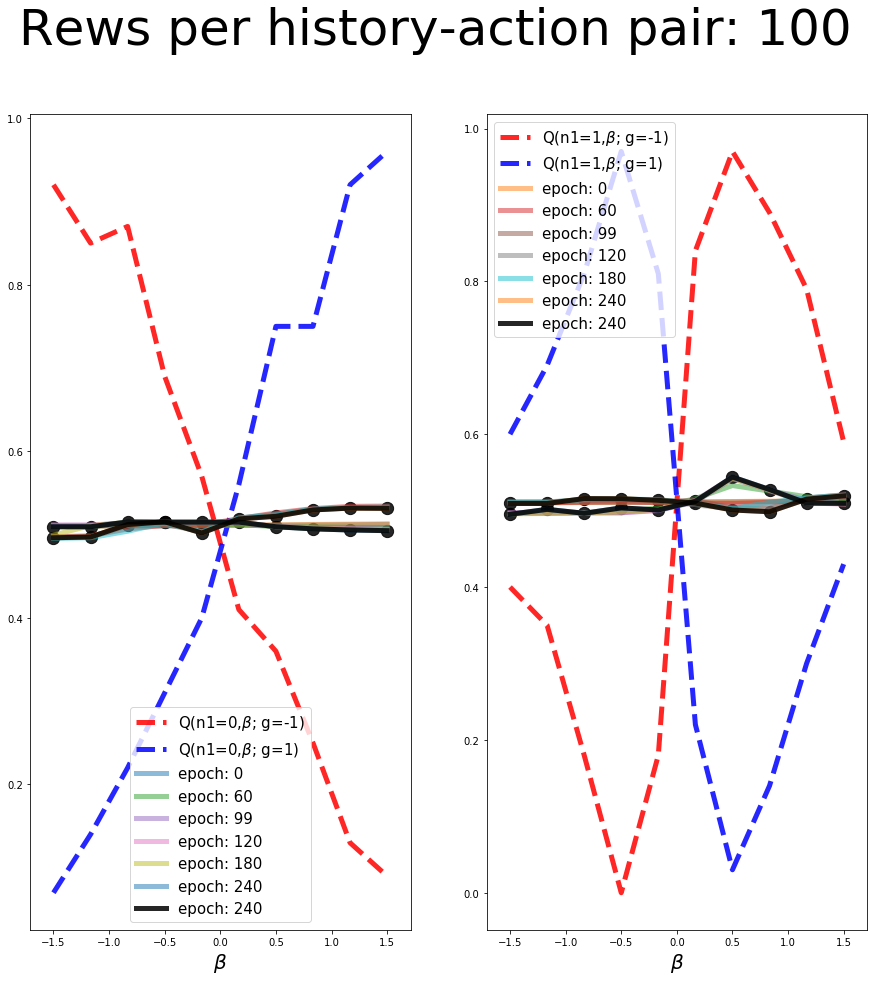

In [182]:
histo_preds1, mean_values1,_ = learning_problem(100,epochs=300, number_of_splits=400,number_of_betas=10, batch_size=32, lr=0.001) 
plot_results(histo_preds1,mean_values1, title="Rews per history-action pair: 100")